In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow import keras    
from sklearn.model_selection import train_test_split
from scipy.stats import norm

In [2]:
rs = [3400,30] #redshift, distance cutoff for box that will be used  

#importing simulation box 
data = np.load("C:/Users/yaras/Documents/Research/Feldman/MLdata/ML100-error4.npy")

#full box 
redshift0 = data[:,0] 
distance0 = data[:,2]
distance_mod0 = data[:,1]
velocity0 = data[:,3]

#taking full box and redefining it with cutoffs 
inds = np.where(redshift0 <= rs[0])
redshift = redshift0[inds]
distance = distance0[inds]
distance_mod = distance_mod0[inds]
velocity = velocity0[inds]

In [3]:
# print(redshift)
# print(redshift.shape)
# print(distance)
# print(distance_mod)
# print(velocity)

In [4]:
# # testing stuff
# # trying to really figure out how axes work

# a = np.arange(0,8).reshape(2,2,2)
# b = np.arange(12,20).reshape(2,2,2)

# # print(a)
# # print(b)

# print(np.stack((a,b)).shape)
# print(np.stack((a,b)))
# print(np.stack((a,b), axis=1))
# print(np.stack((a,b), axis=2))
# print(np.stack((a,b), axis=3))
# print(np.stack((a,b), axis=-1))

In [5]:
#making inputs and outputs into cohesive arrays 
X = np.stack([redshift / np.max(np.abs(redshift)), \
        distance_mod / np.max(np.abs(distance_mod))], \
        axis=-1)
y = np.stack([velocity / np.max(np.abs(velocity)), \
        distance / np.max(np.abs(distance))], \
        axis=-1)

In [6]:
# print(X)
# print(y)

In [7]:
#splitting data into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
#this model is a neural net
#characterized by ALL TANH ACTIVATION FUNCTIONS, AND AUTOMATED LEARNING RATES WITH LOOP 
#you can customize how many layers you have, the number of nodes in them, 
#and the activation function 
model8 = keras.models.Sequential()
model8.add(keras.layers.InputLayer(input_shape=[2]))
model8.add(keras.layers.Dense(25, activation='tanh'))
model8.add(keras.layers.Dense(50, activation='tanh'))
model8.add(keras.layers.Dense(100, activation='tanh'))
model8.add(keras.layers.Dense(50, activation='tanh'))
model8.add(keras.layers.Dense(25, activation='tanh'))
model8.add(keras.layers.Dense(2, activation='tanh'))

#starting off with an optimizer that has a certain learning rate 
optimizer = keras.optimizers.Adam()

#finalizing model and choosing loss function 
model8.compile(loss='mean_squared_error', optimizer=optimizer)

#initial conditions
# learningrate = 0.001
epoch_step = 4 #epochs will go in sets of 4 before changing 
epoch_lower = 0 #initial 
epoch_upper = epoch_step #initial 
threshold = 0.005 #threshold of loss difference between epochs 
while epoch_upper < 21: #adding on 20 epochs 
    a = model8.fit(X_train, y_train, initial_epoch=epoch_lower, epochs=epoch_upper)
    print(a.history['loss']) #this is how  you get the loss when the model above is fit with the given lr
    epoch_lower += epoch_step
    epoch_upper += epoch_step  

Epoch 1/4
5278/5278 [==============================] - 15s 3ms/step - loss: 0.0123
Epoch 2/4
5278/5278 [==============================] - 11s 2ms/step - loss: 0.0104
Epoch 3/4
5278/5278 [==============================] - 11s 2ms/step - loss: 0.0101
Epoch 4/4
5278/5278 [==============================] - 11s 2ms/step - loss: 0.0100
[0.012264062650501728, 0.010351547040045261, 0.01012474112212658, 0.010038516484200954]
Epoch 5/8
5278/5278 [==============================] - 12s 2ms/step - loss: 0.0100
Epoch 6/8
5278/5278 [==============================] - 10s 2ms/step - loss: 0.0100
Epoch 7/8
5278/5278 [==============================] - 11s 2ms/step - loss: 0.0099
Epoch 8/8
5278/5278 [==============================] - 10s 2ms/step - loss: 0.0099
[0.010016724467277527, 0.009980443865060806, 0.009921759366989136, 0.009900370612740517]
Epoch 9/12
5278/5278 [==============================] - 11s 2ms/step - loss: 0.0098
Epoch 10/12
5278/5278 [==============================] - 11s 2ms/step - los

In [9]:
def dist_vel(y_pred,y_test,rs,distance):
    
    fig = plt.figure()
    fig.set_figheight(8) 
    fig.set_figwidth(20) 
    m = np.where(y_pred[:,1]*np.max(np.abs(distance)) <= rs[1])
    predvel = y_pred[:,0][m]#*1.2
    preddist = y_pred[:,1][m]
    
    #plotting true vs true distance and predicted distances along line 
    a = fig.add_subplot(1,2,1)
    plt.plot(y_test[:,1][m],preddist,'.')
    plt.plot(y_test[:,1][m],y_test[:,1][m])
    plt.title('Predicted vs True Distances')
    
    #same as above but for velocity 
    a = fig.add_subplot(1,2,2)
    plt.subplot(1, 2, 2)
    plt.plot(y_test[:,0][m], predvel, '.')
    plt.plot(y_test[:,0][m], y_test[:,0][m])
    plt.title('Predicted vs True Velocities')
    
def hist_resids(y_pred,y_test,rs,distance):
    m = np.where(y_pred[:,1]*np.max(np.abs(distance)) <= rs[1])
    
    predvel = y_pred[:,0][m]
    preddist = y_pred[:,1][m]
    
    #histogram of velocity residuals 
    vel_resids = (y_test[:,0][m] - predvel)*np.max(np.abs(velocity))
    avg = np.mean(vel_resids)
    a = plt.hist(vel_resids,bins=50)
    plt.axvline(vel_resids.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.title('Velocity Residuals' + 'Avg =' + str(avg))
    mean = np.mean(vel_resids)
    variance = np.var(vel_resids)
    sigma = np.sqrt(variance)
    zx = np.linspace(min(vel_resids), max(vel_resids), 100)
    dx = a[1][1] - a[1][0]
    scale = len(vel_resids)*dx
    plt.plot(zx, norm.pdf(zx, mean, sigma)*scale)
    plt.text(-1200,700,'sigma ='+str(sigma),color='black')
    plt.text(-1200,450,'mean ='+str(mean),color='black')

    plt.savefig('NN Velocity Residuals',transparent=True)
    plt.show()
    
    #velocity residuals plot 
    plt.plot(y_pred[:,1][m]*np.max(np.abs(distance)),vel_resids,'bo',markersize='.5')
    plt.axhline(0, color='k', linestyle='dashed', linewidth=1)
    plt.title(str(rs))
    plt.xlabel('PREDICTED distance')
    plt.ylabel('Velocity Residual')
    #plt.ylim(-800,800)
    plt.savefig('RF Residual Dist ' + str(rs),transparent=True)
    plt.show()

1320/1320 [==============================] - 1s 751us/step


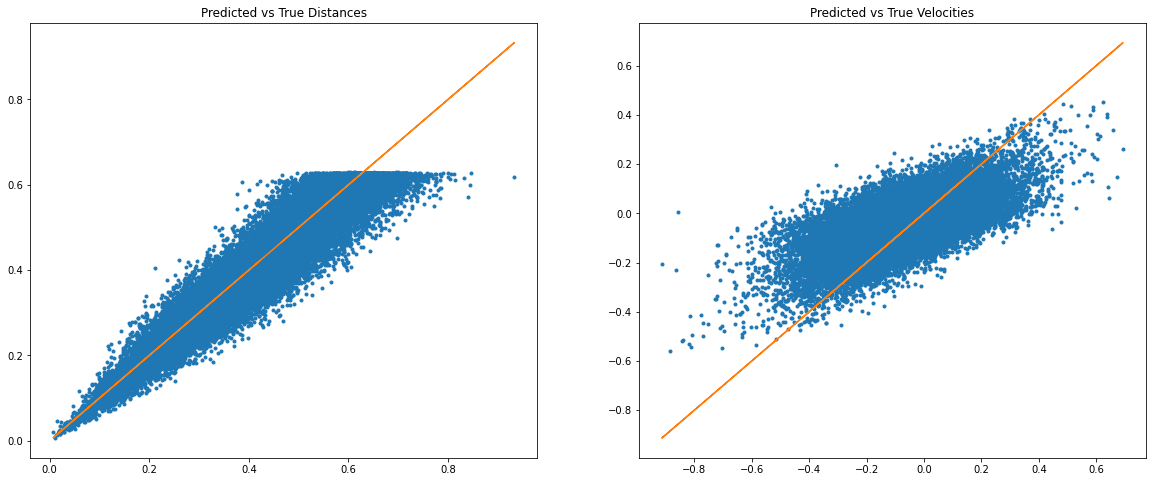

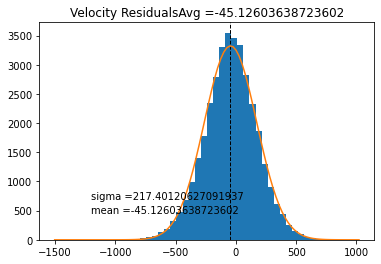

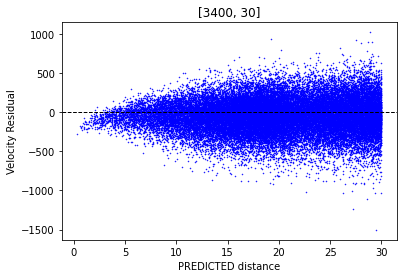

In [10]:
#Automated LR, all tanh 
preds = model8.predict(X_test)
dist_vel(preds,y_test,rs,distance)
plt.show()
hist_resids(preds,y_test,rs,distance)